In [93]:
%load_ext tensorboard

# import torch and other libraries
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import trange

from tqdm import tqdm 
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from tifffile import imread
from pathlib import Path
import json
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import utils
from augmend import Augmend, Elastic, Identity, FlipRot90, Rotate

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [161]:
root = '../'

augment = True
use_gputools = True
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [102]:
X0 = sorted(Path(f'{root}/data/images/').glob('*.tif'))
Y0 = sorted(Path(f'{root}/data/masks/').glob('*.tif'))
json_files = sorted(Path(f'{root}/data/labels/').glob('*.json'))

for x,y,j in zip(X0,Y0,json_files):
    print('------')
    print(x)
    print(y)
    print(j)

X0 = list(map(imread,X0))
X0 = [utils.normalize(x[:, 0, :, :]) for x in X0]
Y0 = list(map(imread,Y0))
Y0 = [clear_border(y) for y in Y0]

C0 = []
for el in json_files:
    with open(el, 'r') as fp:
        class_dict = json.load(fp)
        C0.append({int(k):int(v) for k,v in class_dict.items() if int(k) > 0})

classes = set()
for c in C0:
    for k, item in c.items():
        classes.add(item)
print( classes)
n_classes = len(classes) 
print(n_classes)

------
../data/images/fish2_nasal_15-75z.tif
../data/masks/fish2_nasal_15-75z.tif
../data/labels/fish2_nasal_15-75z_corrected.json
------
../data/images/fish2_nasal_20-80z.tif
../data/masks/fish2_nasal_20-80z.tif
../data/labels/fish2_nasal_20-80z.json
------
../data/images/fish2_nasal_25-85z.tif
../data/masks/fish2_nasal_25-85z.tif
../data/labels/fish2_nasal_25-85z.json
------
../data/images/fish2_temporal_10-70z.tif
../data/masks/fish2_temporal_10-70z.tif
../data/labels/fish2_temporal_10-70z.json
------
../data/images/fish2_temporal_20-81z.tif
../data/masks/fish2_temporal_20-81z.tif
../data/labels/fish2_temporal_20-81z.json
------
../data/images/fish2_temporal_5-65z.tif
../data/masks/fish2_temporal_5-65z.tif
../data/labels/fish2_temporal_5-65z_corrected.json
{1, 2, 3, 4, 5, 6, 7, 8}
8


In [103]:
# create crops 
shape = (32, 64, 64)

X, Y = [], []

for x0, y0, c in tqdm(zip(X0, Y0, C0), total=len(X0)):
    for r in regionprops(y0):
        mask = y0[r.slice]==r.label
        x = x0[r.slice].copy()
        x[~mask] = 0
        x = utils.pad_to_shape(x, shape, mode='constant')
        y = c[r.label]-1
        X.append(x)
        Y.append(y) 
        
print(len(X))

X = np.stack(X)
Y = np.stack(Y)


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 19.32it/s]


401


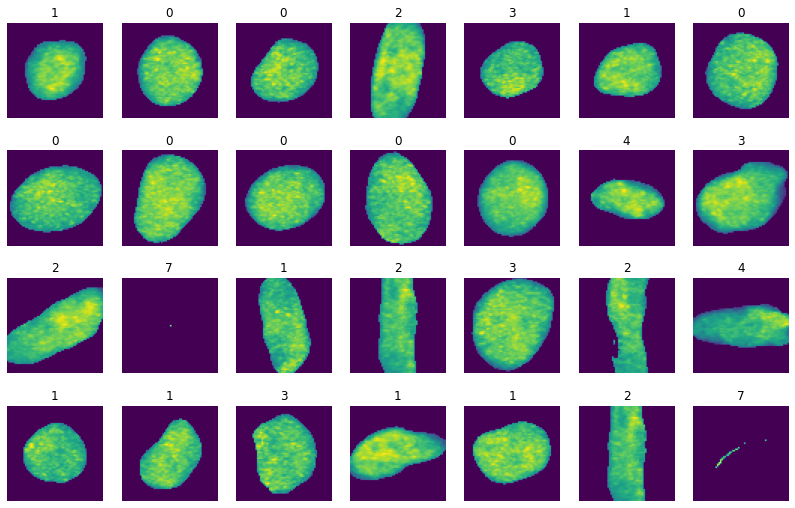

In [104]:
n_plot = 28
plt.figure(figsize=(14,9))
for i, ind in enumerate(np.random.choice(range(len(X)),n_plot)):
    plt.subplot(4,n_plot//4,i+1)
    plt.imshow(np.max(X[ind],0))
    plt.axis('off')
    plt.title(Y[ind])


# Model (small resnet)

In [105]:
class ResnetBlock3D(torch.nn.Module):
    def __init__(self, n_in ,n_out,stride = 1):
        super().__init__()
        norm_layer = nn.BatchNorm3d
        
        self.conv1 = torch.nn.Conv3d(n_in,n_out,3,stride=stride,padding=1,bias=False)        
        self.bn1 = norm_layer(n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv3d(n_out,n_out,3,stride=1,padding=1,bias=False)        
        self.bn2 = norm_layer(n_out)
        
        if stride==1 and n_in==n_out:
            self.after_ident = torch.nn.Identity()
        else:
            self.after_ident = torch.nn.Sequential(
                        torch.nn.Conv3d(n_in, n_out, kernel_size=1, stride=stride),
                        torch.nn.BatchNorm3d(n_out))

    def forward(self, x):
        identity = self.after_ident(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out
    
    
class SimpleResnet3D(torch.nn.Module):
    def __init__(self, n_in=1,n_classes=8, n_levels=3, n_inter=64):
        super().__init__()
        self.blocks = tuple(ResnetBlock3D(n_in if i==0 else n_inter, n_inter, stride=2) for i in range(n_levels))
        self.pool = torch.nn.AdaptiveAvgPool3d((1,1,1))
        self.fc = torch.nn.Linear(n_inter, n_classes)
    def forward(self,x):
        for block in self.blocks:
            x = block(x) 
            
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        

In [106]:
model = SimpleResnet3D(n_in=1, n_classes=8)

x = torch.ones((1,1,32,64,64))

model(x).shape

torch.Size([1, 8])

# Training

In [152]:
data_train = TensorDataset(torch.tensor(X[:,np.newaxis]).float(),torch.tensor(Y).long())
data_val = TensorDataset(torch.tensor(X[:,np.newaxis]).float(),torch.tensor(Y).long())

aug = Augmend()

if augment:
    aug.add([FlipRot90(axis=(2,3)),Identity()])
    aug.add([Rotate(axis=(2,3)),Identity()])
#     aug.add([Elastic(grid=10, amount=2, order=0, axis=(2,3), use_gpu=use_gputools),Identity()])


data_train = aug.torch_wrap(data_train)


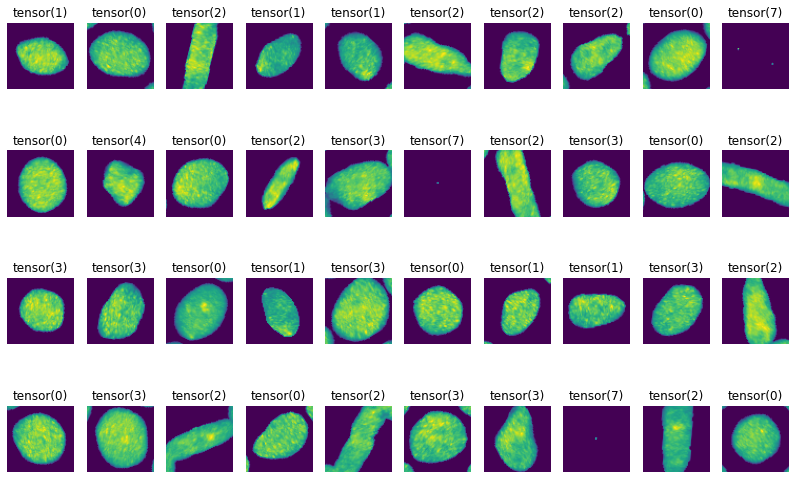

In [158]:
n_plot = 40
plt.figure(figsize=(14,9))
for i, ind in enumerate(np.random.choice(range(len(X)),n_plot)):
    x,y = data_train[ind]
    plt.subplot(4,n_plot//4,i+1)
    plt.imshow(np.max(x.numpy(),(0,1)))
    plt.axis('off')
    plt.title(y)

In [159]:

loader_train = DataLoader(data_train, batch_size=8, shuffle=True)
loader_val = DataLoader(data_train, batch_size=8, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [160]:
utils.run_training(model, optimizer, loader_train, loader_val, device=device, name='test', n_epochs=100)

  0%|                                                                                         | 0/10 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [83]:
next(iter(loader_train))[0].shape

torch.Size([8, 32, 64, 64])